In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '28px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

In [ ]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error, log_loss 
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [ ]:
project_dir = 'drive/My Drive/luke-hair-loss'
df = pd.read_csv(f"{project_dir}/Luke_hair_loss_documentation.csv")
df.columns = [x.strip() for x in df.columns.values]
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df = df.sort_values('date').reset_index(drop=True)
df['hair_loss_code'] = df['hair_loss'].replace(['Few', 'Medium', 'Many', 'A lot'], range(4))
df['pressure_level_code'] = df['pressure_level'].replace(['Low', 'Medium', 'High', 'Very High'], range(4))
df['stress_level_code'] = df['stress_level'].replace(['Low', 'Medium', 'High', 'Very High'], range(4))
df['dandruff_code'] = df['dandruff'].replace(['None', 'Few', 'Many'], range(3))
df['swimming_code'] = df['swimming'].replace(['No', 'Yes'], range(2))
df['hair_washing_code'] = df['hair_washing'].replace(['N', 'Y'], range(2))

cols = ["hair_loss", "pressure_level", "stress_level", 
        "dandruff", "swimming", "school_assesssment", 
        'hair_washing']

for col in ['shampoo_brand','school_assesssment']:
  df[f'{col}_code'] = df[col].astype('category').cat.codes
  cols.append(col)

code_cols = [f"{x}_code" for x in cols] 
num_cols = ['stay_up_late', 'coffee_consumed', 'brain_working_duration', 'hair_grease', 'libido']
for col in ['hair_loss', 'stress_level']:
  df[f'{col}_avg'] = df[f'{col}_code'].rolling(7).mean()
df['next_day_hair_loss'] = df['hair_loss_code'].shift(-1)  
df['active_hair_loss_next_day'] = df['next_day_hair_loss'].replace(range(4), [0,0,1,1])
df.shape

<IPython.core.display.Javascript object>

(400, 26)

<IPython.core.display.Javascript object>

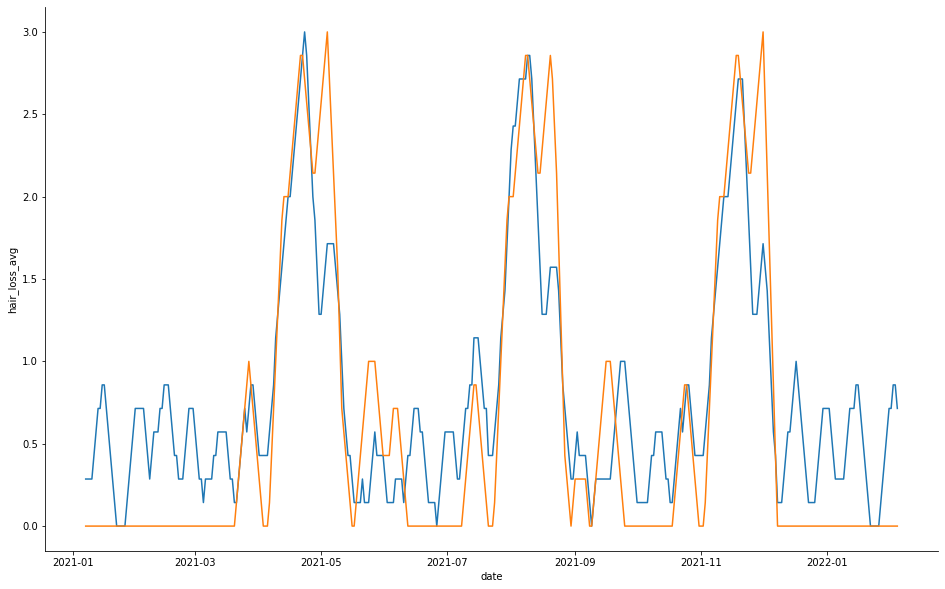

In [ ]:
fig = plt.figure(figsize=(16,10))
sns.lineplot(data=df, x='date', y='hair_loss_avg')
sns.lineplot(data=df, x='date', y='stress_level_avg')
# sns.lineplot(data=df, x='date', y='next_day_hair_loss')
sns.despine()
plt.show()

In [ ]:
feats = ['pressure_level_code', 'stress_level_code', 'dandruff_code', 
         'swimming_code', 'school_assesssment_code', 'hair_washing_code',
         'shampoo_brand_code', 'school_assesssment_code'] + num_cols
target = 'active_hair_loss_next_day'

<IPython.core.display.Javascript object>

In [ ]:
model_data = df.dropna(subset=feats+[target])

for col in feats: 
  model_data[f"{col}_scaled"] = scale(model_data[col])

scaled_feats = [f"{x}_scaled" for x in feats]

folds = 10
kf = KFold(folds)
s = pd.Series()
df_diagnostic = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = LogisticRegression()
  model.fit(train_data.loc[:, scaled_feats], train_data[target])
  s = s.append(pd.DataFrame(model.predict_proba(test_data.loc[:, scaled_feats]), index=test_data.index)[1])

  _df = pd.DataFrame(model.coef_, columns=scaled_feats)
  df_diagnostic = df_diagnostic.append(_df, ignore_index=True)

model_data[f"{target}_pred"] = s
model_data[f"{target}_naive"] = model_data[target].mean()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from sklearn.preprocessing import scale

<IPython.core.display.Javascript object>

In [ ]:
df_diagnostic

<IPython.core.display.Javascript object>

,pressure_level_code,stress_level_code,dandruff_code,swimming_code,school_assesssment_code,hair_washing_code,shampoo_brand_code,school_assesssment_code,stay_up_late,coffee_consumed,brain_working_duration,hair_grease,libido
0,1.018511,1.409500,0.798735,-0.408276,0.443990,0.040535,-0.408939,0.443990,-0.608046,0.665291,-0.200538,1.201549,0.506715
1,1.018833,1.397662,0.792942,-0.407724,0.441112,0.034459,-0.451642,0.441112,-0.610824,0.673794,-0.203309,1.189274,0.508286
2,0.851576,1.605522,0.761810,-0.370733,0.421789,0.050462,-0.490492,0.421789,-0.382111,0.631177,-0.241606,1.217317,0.577887
3,0.869629,1.445507,0.830927,-0.443028,0.495290,0.059153,-0.475924,0.495290,-0.589908,0.560196,-0.142390,1.186181,0.513054
4,1.246203,1.500200,0.827712,-0.285851,0.447407,0.220285,-0.370578,0.447407,-0.635465,0.732143,-0.247803,1.175529,0.590312
5,0.997826,1.332679,0.715691,-0.367399,0.435025,-0.243403,-0.445446,0.435025,-0.561238,0.569621,-0.153659,1.141392,0.371291
6,1.010561,1.418636,0.800714,-0.412809,0.444456,0.039752,-0.432117,0.444456,-0.602983,0.661159,-0.199881,1.191836,0.505832
7,1.040456,1.353256,0.791124,-0.361967,0.413356,-0.086387,-0.182186,0.413356,-0.487309,0.535884,-0.215153,1.250696,0.426040
8,1.126534,1.251523,0.765428,-0.431714,0.460651,0.262159,-0.432195,0.460651,-0.820742,0.746623,-0.132106,1.160779,0.504459
9,1.007324,1.386161,0.782394,-0.396736,0.440374,0.038503,-0.469513,0.440374,-0.619845,0.686582,-0.203003,1.182827,0.512576


In [ ]:
loss_pred = log_loss(model_data[target], model_data[f"{target}_pred"])
loss_naive = log_loss(model_data[target], model_data[f"{target}_naive"])
loss_pred, loss_naive

<IPython.core.display.Javascript object>

(0.07324488280624811, 0.44301310772434516)

<IPython.core.display.Javascript object>

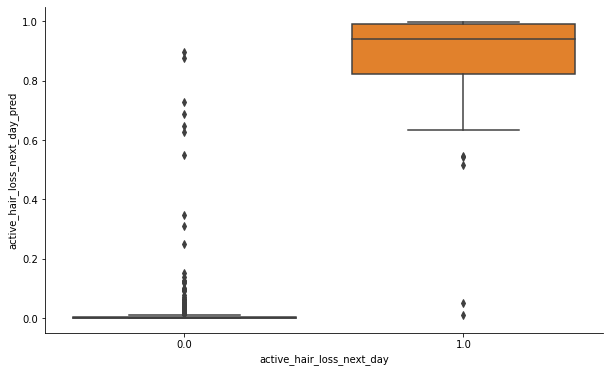

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=model_data, x=target, y=f"{target}_pred")
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

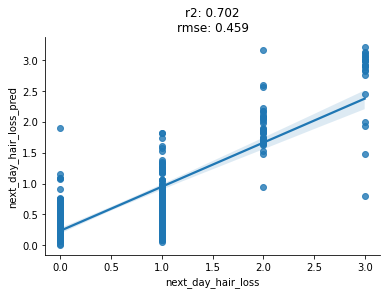

In [ ]:
r2 = pearsonr(model_data[target], model_data[f"{target}_pred"])[0]**2
rmse = mean_squared_error(model_data[target], model_data[f"{target}_pred"])**0.5

sns.regplot(data=model_data, x=target, y=f"{target}_pred")
plt.title(f"r2: {round(r2, 3)}\nrmse: {round(rmse, 3)}")
sns.despine()
plt.show()